#**AAKASH DESHMANE**
# UIN : 133008022
## ECEN 743 ASSIGNMENT 5
## POLICY GRADIENT IMPLEMENTATION OF LUNAR LANDER



In [1]:
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 42.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce t

In [2]:
"""
ECEN 743: Reinforcement Learning
Policy Gradient Assignment
Code tested using
	1. gymnasium 0.27.1
	2. box2d-py  2.3.5
	3. pytorch   2.0.0
	4. Python    3.9.12
1 & 2 can be installed using pip install gymnasium[box2d]

General Instructions
1. This code consists of TODO blocks, read them carefully and complete each of the blocks
2. Type your code between the following lines
			###### TYPE YOUR CODE HERE ######
			#################################
3. The default hyperparameters should be able to solve LunarLander-v2 in the continuous setting
4. It is not necessary to modify the rest of the code for this assignment, feel free to do so if needed.

"""
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import math
from collections import deque
import matplotlib.pyplot as plt


VALUE NETWORK

In [3]:
class value_network(nn.Module):
	'''
	Value Network: Designed to take in state as input and give value as output
	Used as a baseline in Policy Gradient (PG) algorithms
	'''
	def __init__(self,state_dim):
		'''
			state_dim (int): state dimenssion
		'''
		super(value_network, self).__init__()
		self.l1 = nn.Linear(state_dim, 64)
		self.l2 = nn.Linear(64, 64)
		self.l3 = nn.Linear(64, 1)

	def forward(self,state):
		'''
		Input: State
		Output: Value of state
		'''
		v = F.tanh(self.l1(state))
		v = F.tanh(self.l2(v))
		return self.l3(v)

POLICY NETWORK 

In [4]:
class policy_network(nn.Module):
	'''
	Policy Network: Designed for continous action space, where given a 
	state, the network outputs the mean and standard deviation of the action
	'''
	def __init__(self,state_dim,action_dim,log_std = 0.0):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
			log_std (float): log of standard deviation (std)
		"""
		super(policy_network, self).__init__()
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.l1 = nn.Linear(state_dim,64)
		self.l2 = nn.Linear(64,64)
		self.mean = nn.Linear(64,action_dim)
		self.log_std = nn.Parameter(torch.ones(1, action_dim) * log_std)

	
	def forward(self,state):
		'''
		Input: State
		Output: Mean, log_std and std of action
		'''
		a = F.tanh(self.l1(state))
		a = F.tanh(self.l2(a))
		a_mean = self.mean(a)
		a_log_std = self.log_std.expand_as(a_mean)
		a_std = torch.exp(a_log_std)		
		return a_mean, a_log_std, a_std

	def select_action(self, state):
		'''
		Input: State
		Output: Sample drawn from a normal disribution with mean and std
		'''
		a_mean, _, a_std = self.forward(state)
		action = torch.normal(a_mean, a_std)
		return action
	
	def get_log_prob(self, state, action):
		'''
		Input: State, Action
		Output: log probabilities
		'''
		mean, log_std, std = self.forward(state)
		var = std.pow(2)
		log_density = -(action - mean).pow(2) / (2 * var) - 0.5 * math.log(2 * math.pi) - log_std
		return log_density.sum(1, keepdim=True)

POLICY GRADIENT AGENT

In [20]:
class PGAgent():
	'''
	An agent that performs different variants of the PG algorithm
	'''
	def __init__(self,
	 state_dim, 
	 action_dim,
	 discount=0.99,
	 lr=1e-3,
	 gpu_index=0,
	 seed=0,
	 env="LunarLander-v2"
	 ):
		"""
			state_size (int): dimension of each state
			action_size (int): dimension of each action
			discount (float): discount factor
			lr (float): learning rate
			gpu_index (int): GPU used for training
			seed (int): Seed of simulation
			env (str): Name of environment
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.discount = discount
		self.lr = lr
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')
		self.env_name = env
		self.seed = seed
		self.policy = policy_network(state_dim,action_dim)
		self.value = value_network(state_dim)
		self.optimizer_policy = torch.optim.Adam(self.policy.parameters(), lr=self.lr)
		self.optimizer_value = torch.optim.Adam(self.value.parameters(), lr=self.lr)

	def sample_traj(self,batch_size=2000,evaluate = False):
		'''
		Input: 
			batch_size: minimum batch size needed for update
			evaluate: flag to be set during evaluation
		Output:
			states, actions, rewards,not_dones, episodic reward 	
		'''
		self.policy.to("cpu") #Move network to CPU for sampling
		env = gym.make(self.env_name,continuous=True)
		states = []
		actions = []
		rewards = []
		n_dones = []
		curr_reward_list = []
		while len(states) < batch_size:
			state, _ = env.reset(seed=self.seed)
			curr_reward = 0
			for t in range(1000):
				state_ten = torch.from_numpy(state).float().unsqueeze(0)
				with torch.no_grad():
					if evaluate:
						action = self.policy(state_ten)[0][0].numpy() # Take mean action during evaluation
					else:
						action = self.policy.select_action(state_ten)[0].numpy() # Sample from distribution during training
				action = action.astype(np.float64)
				n_state,reward,terminated,truncated,_ = env.step(action) # Execute action in the environment
				done = terminated or truncated
				states.append(state)
				actions.append(action)
				rewards.append(reward)
				n_done = 0 if done else 1
				n_dones.append(n_done)
				state = n_state
				curr_reward += reward
				if done:
					break
			curr_reward_list.append(curr_reward)
		if evaluate:
			return np.mean(curr_reward_list)
		return states,actions,rewards,n_dones, np.mean(curr_reward_list)
	



	def update(self,states,actions,rewards,n_dones,update_type='Baseline'):
		'''
		TODO: Complete this block to update the policy using different variants of PG
		Inputs:
			states: list of states
			actions: list of actions
			rewards: list of rewards
			n_dones: list of not dones
			update_type: type of PG algorithm
		Output: 
			None
		'''
		self.policy.to(self.device) #Move policy to GPU
		if update_type == "Baseline":
			self.value.to(self.device)	#Move value to GPU
		states_ten = torch.from_numpy(np.stack(states)).to(self.device)   #Convert to tensor and move to GPU
		action_ten = torch.from_numpy(np.stack(actions)).to(self.device)  #Convert to tensor and move to GPU
		rewards_ten = torch.from_numpy(np.stack(rewards)).to(self.device) #Convert to tensor and move to GPU
		n_dones_ten = torch.from_numpy(np.stack(n_dones)).to(self.device) #Convert to tensor and move to GPU

		
		if update_type == "Rt":

			rt = torch.zeros(rewards_ten.shape[0],1).to(self.device)
			rt_total = 0
			s = rewards_ten.shape[0]

			# CALCULATE REWARD
			for t in reversed(range(s)):
					rt_total = rewards_ten[t] + rt_total * self.discount *n_dones_ten[t]
					rt[t] = rt_total

			# CALCULATE LOG PROBABILITIES
			log_prob = self.policy.get_log_prob(states_ten, action_ten)
			l = log_prob * rt.detach()
			loss = -(l).mean()

			# UPDATE POLICY
			self.optimizer_policy.zero_grad()
			loss.backward()
			self.optimizer_policy.step()

		if update_type == 'Gt':
			'''
			TODO: Peform PG using reward_to_go
			1. Compute reward_to_go (gt) using rewards_ten and n_dones_ten
			2. gt should be of the same length as rewards_ten
			3. Compute log probabilities using states_ten and action_ten
			4. Compute policy loss and update the policy
			'''
			

			###### TYPE YOUR CODE HERE ######
			#################################

			# STEP 1 : COMPUTE REWARD
			g = 0

			# STEP 2 : gt SHOULD BE OF THE SAME LENGTH AS rewards_ten
			gt = torch.zeros(rewards_ten.shape[0],1).to(self.device)
	 
			for i in reversed(range(rewards_ten.size(0))):
				g = rewards_ten[i] + self.discount * g * (n_dones_ten[i])
				gt[i] = g

			gt = (gt - gt.mean()) / gt.std() #Helps with learning stablity

			# STEP 3 : COMPUTE LOG PROBABILITIES USING states_ten AND action_ten
			log_prob = self.policy.get_log_prob(states_ten, action_ten)
			l = log_prob * gt.detach()
			loss = -(l).mean()
	 
	 		# STEP 4 : COMPUTE POLICY LOSS AND UPDATE POLICY

			self.optimizer_policy.zero_grad()
			loss.backward()
			self.optimizer_policy.step()

		if update_type == 'Gt_with_Baseline':
			'''
			TODO: Peform PG using reward_to_go and baseline
			1. Compute values of states, this will be used as the baseline 
			2. Compute reward_to_go (gt) using rewards_ten and n_dones_ten
			3. gt should be of the same length as rewards_ten
			4. Compute advantages 
			5. Update the value network to predict gt for each state (L2 norm)
			6. Compute log probabilities using states_ten and action_ten
			7. Compute policy loss (using advantages) and update the policy
			'''
			state_t = torch.FloatTensor(states).to(self.device)

			# STEP 1 CALCULATE VALUES  
			with torch.no_grad():
					self.value.to(self.device)
					val = self.value(states_ten).to(self.device)

			# gt SHOULD HAVE THE SAME LENGTH AS rewards_ten	
			gt = torch.zeros(rewards_ten.shape[0],1).to(self.device)
	 
			g=0

			# STEP 2 : COMPUTE REWARD-TO-GO (gt) and ADVANTAGES
			returns = torch.zeros((rewards_ten.shape[0], 1)).to(self.device)
			advantages = torch.zeros((rewards_ten.shape[0], 1)).to(self.device)
			s = rewards_ten.size(0)
			for i in reversed(range(s)):
				g = rewards_ten[i] + self.discount * g * n_dones_ten[i]
				gt[i] = g

			# STEP 4 : COMPUTE ADVANTAGES
			advantages = gt - val


			# Normalize advantages
			advantages = (advantages - advantages.mean()) / advantages.std()
			
			# STEP 5 : UPDATE VALUE NETWORK TO PREDICT gt FOR EACH STATE (L2 NORM)
			loss = torch.nn.MSELoss()
			value_loss = loss(self.value(states_ten), gt)
			self.optimizer_value.zero_grad()
			value_loss.backward()
			self.optimizer_value.step()

			# STEP 6 : COMPUTE LOG PROBABILITIES USING states_ten and Compute log probabilities using states_ten and action_ten
			log_probs = self.policy.get_log_prob(states_ten, action_ten)

			# STEP 7 : COMPUTE POLICY LOSS AND UPDATE POLICY
			self.optimizer_policy.zero_grad()
			l = log_probs * advantages.detach()
			loss = -(l).mean()
			loss.backward()
			self.optimizer_policy.step()
	    # _________________________________________________________________________

MAIN FUNCTION FOR THE CODE

In [34]:
def main_fn(algo):
	env_type = "LunarLander-v2"				  # Gymnasium environment name
	seed = 0               							# Sets Gym, PyTorch and Numpy seeds
	n_iter = 200          							# Maximum number of training iterations
	discount = 0.99                  		# Discount factor
	batch_size = 5000     							# Training samples in each batch of training
	lr = 6e-3             							# Learning rate
	gpu_index = 0		     								# GPU index
	algo = algo		 						         	# PG algorithm type. Baseline_with_Gt/Gt/Rt
	

	# Making the environment	
	env = gym.make(env_type,continuous=True)

	# Setting seeds
	torch.manual_seed(seed)
	np.random.seed(seed)
	random.seed(seed)

	state_dim = env.observation_space.shape[0]
	action_dim = env.action_space.shape[0]

	kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":discount,
		"lr":lr,
		"gpu_index":gpu_index,
		"seed":seed,
		"env":env_type
	}	
	learner = PGAgent(**kwargs) # Creating the PG learning agent
	av_rewards=[]
	moving_window = deque(maxlen=10)
	old_reward = 0
	old_eval_reward = 0
	old_train_reward = 0

	for e in range(n_iter):
		'''
		Steps of PG algorithm
			1. Sample environment to gather data using a policy
			2. Update the policy using the data
			3. Evaluate the updated policy
			4. Repeat 1-3
		'''
		states,actions,rewards,n_dones,train_reward = learner.sample_traj(batch_size=batch_size)
		learner.update(states,actions,rewards,n_dones,algo)
		eval_reward= learner.sample_traj(evaluate=True)
		moving_window.append(eval_reward)
		print('Training Iteration {} Training Reward: {:.2f} Evaluation Reward: {:.2f} \
		Average Evaluation Reward: {:.2f}'.format(e,train_reward,eval_reward,np.mean(moving_window)))
		
		av_rewards.append(np.mean(moving_window))
	
		if eval_reward > old_eval_reward and train_reward > old_train_reward and np.mean(moving_window)>old_reward and eval_reward > 210 and train_reward > 210 and np.mean(moving_window) > 210:
			old_reward = np.mean(moving_window)
			old_eval_reward = eval_reward
			old_train_reward = train_reward
			torch.save(learner.policy.state_dict(), (algo + '_checkpoint.pth'))
			print("Best result for training iteration {}".format(e))

	"""
	TODO: Write code for
	1. Logging and plotting
	2. Rendering the trained agent 
	"""
	###### TYPE YOUR CODE HERE ######
	################################
	window_size = 20
	averages = []

	for i in range(len(av_rewards)-window_size + 1):
			window = av_rewards[i:i+window_size]
			average = sum(window) / window_size
			averages.append(average)
		 
	plt.plot(averages, color='g')
	plt.ylabel('Episodic Cumulative Reward')
	plt.xlabel('Episode #')
	plt.title('Curve for Episodic Cumulative Reward for algorithm = {}'.format(algo))
	plt.show()

HYPERPARAMETERS TUNED TO:
* ITERATIONS : 200
* DISCOUNT : 0.99
* BATCH SIZE : 5000
* LEARNING RATE : 6e-4


1) REINFORCE:

1) REINFORCE ALGORITHM 
 TRAINING FOR Rt: 

Training Iteration 0 Training Reward: -80.02 Evaluation Reward: -232.22 		Average Evaluation Reward: -232.22
Training Iteration 1 Training Reward: -235.48 Evaluation Reward: -88.72 		Average Evaluation Reward: -160.47
Training Iteration 2 Training Reward: -143.70 Evaluation Reward: -102.33 		Average Evaluation Reward: -141.09
Training Iteration 3 Training Reward: -71.00 Evaluation Reward: -393.46 		Average Evaluation Reward: -204.18
Training Iteration 4 Training Reward: -94.70 Evaluation Reward: -151.58 		Average Evaluation Reward: -193.66
Training Iteration 5 Training Reward: -128.36 Evaluation Reward: -88.98 		Average Evaluation Reward: -176.21
Training Iteration 6 Training Reward: -80.86 Evaluation Reward: -46.37 		Average Evaluation Reward: -157.66
Training Iteration 7 Training Reward: -52.87 Evaluation Reward: -36.45 		Average Evaluation Reward: -142.51
Training Iteration 8 Training Reward: -43.91 Evaluation Reward: -64.98 		Average Eval

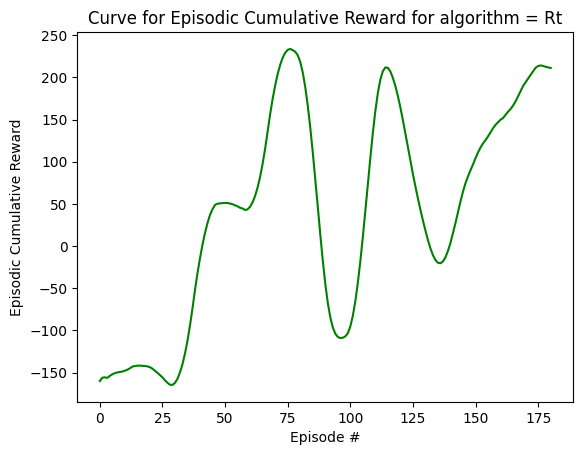

In [37]:
env_type = "LunarLander-v2"

# RUNNING CODE FOR 3 CONDITION :

# 1) REINFORCE ALGORITHM
print("1) REINFORCE ALGORITHM \n TRAINING FOR Rt: \n")
main_fn("Rt")

#_________________________________________________________________________________________________________________________________________________
#_________________________________________________________________________________________________________________________________________________
#_________________________________________________________________________________________________________________________________________________


2) POLICY GRADIENT WITH Gt

2) POLICY GRADIENT 
 TRAINING FOR Gt: 

Training Iteration 0 Training Reward: -80.02 Evaluation Reward: -364.48 		Average Evaluation Reward: -364.48
Training Iteration 1 Training Reward: -251.02 Evaluation Reward: -324.61 		Average Evaluation Reward: -344.55
Training Iteration 2 Training Reward: -171.38 Evaluation Reward: -108.64 		Average Evaluation Reward: -265.91
Training Iteration 3 Training Reward: -63.09 Evaluation Reward: -97.47 		Average Evaluation Reward: -223.80
Training Iteration 4 Training Reward: -107.44 Evaluation Reward: -59.84 		Average Evaluation Reward: -191.01
Training Iteration 5 Training Reward: -125.85 Evaluation Reward: -119.06 		Average Evaluation Reward: -179.02
Training Iteration 6 Training Reward: -73.31 Evaluation Reward: -119.06 		Average Evaluation Reward: -170.45
Training Iteration 7 Training Reward: -53.23 Evaluation Reward: -114.17 		Average Evaluation Reward: -163.42
Training Iteration 8 Training Reward: -61.74 Evaluation Reward: -57.11 		Average Evalu

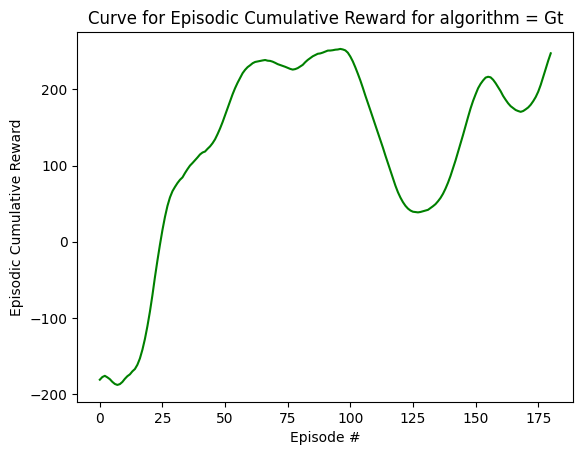

In [36]:

print("2) POLICY GRADIENT \n TRAINING FOR Gt: \n")
main_fn("Gt")

#_________________________________________________________________________________________________________________________________________________
#_________________________________________________________________________________________________________________________________________________
#_________________________________________________________________________________________________________________________________________________


3) POLICY GRADIENT WITH Gt WITH BASELINE:

1) POLICY GRADIENT WITH BASELINE 
 TRAINING FOR Gt WITH BASELINE: 

Training Iteration 0 Training Reward: -80.02 Evaluation Reward: -364.16 		Average Evaluation Reward: -364.16
Training Iteration 1 Training Reward: -250.53 Evaluation Reward: -255.62 		Average Evaluation Reward: -309.89
Training Iteration 2 Training Reward: -161.20 Evaluation Reward: -47.97 		Average Evaluation Reward: -222.58
Training Iteration 3 Training Reward: -74.79 Evaluation Reward: -46.67 		Average Evaluation Reward: -178.60
Training Iteration 4 Training Reward: -61.00 Evaluation Reward: -98.40 		Average Evaluation Reward: -162.56
Training Iteration 5 Training Reward: -105.56 Evaluation Reward: -105.51 		Average Evaluation Reward: -153.05
Training Iteration 6 Training Reward: -65.21 Evaluation Reward: -117.78 		Average Evaluation Reward: -148.02
Training Iteration 7 Training Reward: -47.50 Evaluation Reward: -56.65 		Average Evaluation Reward: -136.59
Training Iteration 8 Training Reward: -44.17 Evaluation Rewar

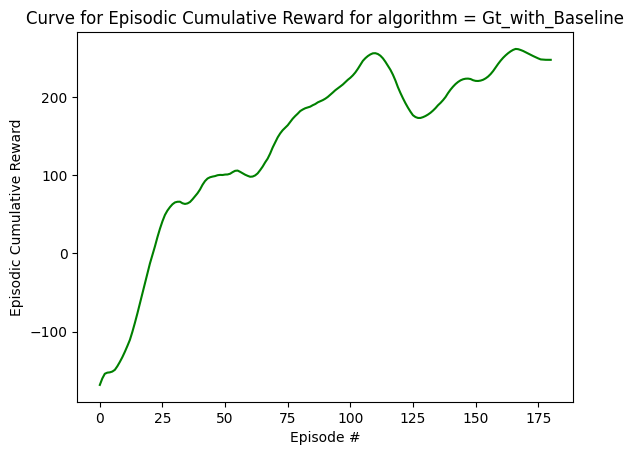

In [35]:
print("1) POLICY GRADIENT WITH BASELINE \n TRAINING FOR Gt WITH BASELINE: \n")
main_fn("Gt_with_Baseline")

#_________________________________________________________________________________________________________________________________________________
#_________________________________________________________________________________________________________________________________________________
#_________________________________________________________________________________________________________________________________________________

THE CODE BELOW IS JUST TO EXPORT THE VIDEO AND DOES NOT TAKE PART IN THE ALGORITHM

In [ ]:
 #For visualization
import gymnasium as gym
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import cv2

VIDEO FUNCTION

In [ ]:
def video_fn(agent, env_name, algo):
    env = gym.make(env_name, continuous = True, render_mode="rgb_array")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(algo+'_video.mp4', fourcc, 30, (600, 400))
    agent.policy.load_state_dict(torch.load(algo+"_checkpoint.pth"))
    agent.policy.eval()
    state, _= env.reset()
    done = False
    while not done:
        frame = env.render()
        video.write(frame)
        state_ten = torch.from_numpy(state).float().unsqueeze(0)
        action = agent.policy.select_action(state_ten)[0].detach().numpy()
        action = action.astype(np.float64)
        n_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated 
        state = n_state
    env.close()
    video.release()


EXPORTING VIDEO

In [ ]:
env_type = "LunarLander-v2"
env = gym.make(env_type, continuous=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
plotter_agent = PGAgent(state_dim,action_dim)
video_fn(plotter_agent, "LunarLander-v2", "Rt")
video_fn(plotter_agent, "LunarLander-v2", "Gt")
video_fn(plotter_agent, "LunarLander-v2", "Gt_with_Baseline")